In [1]:
import numpy as np
import matplotlib.pyplot as plt
import buoypy as bp
from scipy import stats, signal
import utils

CoastSat outputs an array of [X,Y] UTM coordinates for our shoreline. CEM requires an [X,Y,Z] mesh. In the shorelinetogrid function we generate crossshore elevation for our grid using the Dean Profile equation (Dean, 1991): 

$$h(x) = Ax^{m}$$

where:
    <li>*h* = depth (m)</li>
    <li>*x* = cross-shore distance (m)</li> 
    <li>*A* = shape parameter (0.05 to 0.25 based on sed. characteristics, hardcoded to be 0.1)</li>
    <li>*m* = 2/3 (describes the typical concave up shape of beach slope)</li>
       
*Note that while this equation can provide a relatively accurate first cut assesment of nearshore bathymetry, it was designed for planar beaches with uniform slope (i.e., no sand bars or complicated bathymetry)*

In [2]:
# # user input from NDBC buoy (make sure buoy has wave height available)
# station = 46229
# year = np.NAN
# year_range = (2005,2024)

# H = bp.historic_data(station,year,year_range)
# X = H.get_all_stand_meteo()

# # get rid of missing data
# X.mask((X==99.0) | (X==9999.0), inplace=True)
# X.head(3) #preview first 3 lines of table

In [3]:
# # plot relevant data to check it looks ok
# %matplotlib inline
# plotdata = True
# if plotdata == True: utils.plotmeteo(X)

In [4]:
# # extract relevant wave data for CEM
# Hs = np.mean(X.WVHT)
# Tp = np.mean(X.DPD)
# [Dir,count] = stats.mode(X.MWD, keepdims=False, nan_policy='omit') 

# wave_climate = np.array([Hs, Tp, Dir])
# np.savetxt('umpqua_wave_climate_data.txt', wave_climate)


In [5]:
wave_climate = np.loadtxt('umpqua_wave_climate_data.txt')

Hs = wave_climate[0]
Tp = wave_climate[1]
Dir = wave_climate[2]

In [6]:
def rotate_shoreline(x,y,angle='auto'):
    '''This function takes points (x,y) and rotates them by an angle
    The angle is automatically generated by the end points of the shorelines coordinates
    If this approach doesnt work for some reason you may input an angle maually (in degrees).'''
    
    if angle == 'auto':
        sign = -1 if y[-1]>y[0] else 1
        a = sign*np.arctan((y[-1]-y[0])/(x[-1]-x[0]))
    else:
        a = angle*np.pi/180
    # using this roation matix
    xnew = (x ) * np.cos(a) - (y ) * np.sin(a)  
    ynew = (x ) * np.sin(a) + (y ) * np.cos(a) 
    return xnew,ynew


In [7]:
xy = np.loadtxt('/Users/ryan/Documents/ESPIn/coastal2025/coquille_pt_coords.txt')

In [8]:
# shoreline
x=xy[:,0]
y=xy[:,1]
dx=100
dy=100

In [9]:
# Get the sorted indices of x
sorted_indices = np.argsort(x)

# Sort x and reorder y accordingly
x_sorted = x[sorted_indices]
y_sorted = y[sorted_indices]

In [10]:
def fill_gaps(x, y, max_gap):
    x = np.array(x)
    y = np.array(y)
    
    x_filled = []
    y_filled = []

    for i in range(len(x) - 1):
        # Always include the current point
        x_filled.append(x[i])
        y_filled.append(y[i])

        # Compute the gap
        gap = x[i+1] - x[i]

        if gap > max_gap:
            # Number of new points to insert
            num_new = int(np.floor(gap / max_gap))

            # Generate new x values
            new_x = np.linspace(x[i], x[i+1], num=num_new+2)[1:-1]
            new_y = np.linspace(y[i], y[i+1], num=num_new+2)[1:-1]

            x_filled.extend(new_x)
            y_filled.extend(new_y)

    # Don't forget the last point
    x_filled.append(x[-1])
    y_filled.append(y[-1])

    return np.array(x_filled), np.array(y_filled)


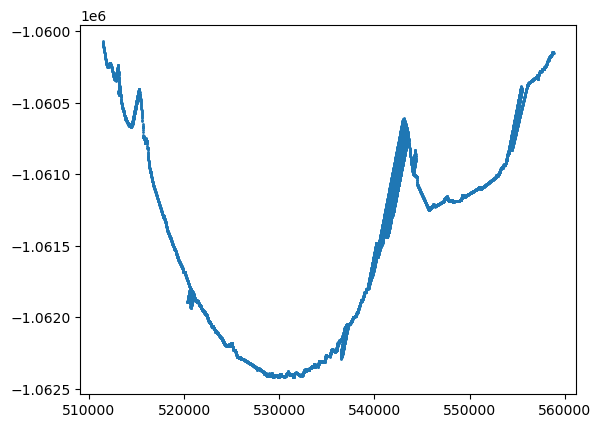

In [11]:
xnew,ynew = rotate_shoreline(x_sorted,y_sorted, -71)

xnew, ynew = fill_gaps(xnew, ynew, 10)

# check the orentation by uncommenting the line below
plt.scatter(xnew,ynew, s=1)

# if it isnt right, input an angle into the function above and rotate manually
# if it looks good, run the cell below

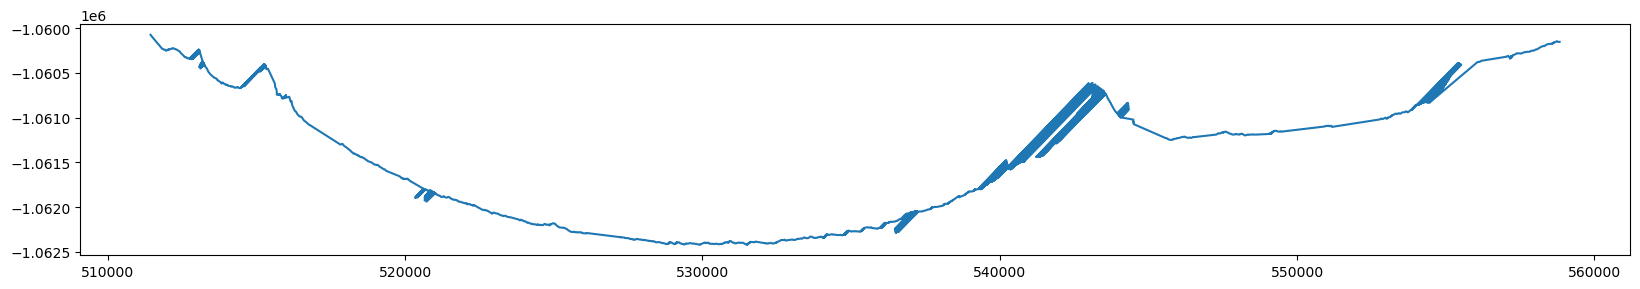

In [12]:
def extend_shoreline(x,y,length):
    '''Extend the length of the shoreline by an amount, "length", on each end.'''
    XL = int(length)
    dx=length//100
    x = np.append(x,np.arange(x[-1],x[-1]+XL+dx,dx))
    y = np.append(y,np.ones([abs(len(y)-len(x))])*y[-1])
    x = np.append(np.flip(x),np.arange(x[0]-XL,x[0]-1,dx))
    y = np.append(np.flip(y),np.ones([abs(len(y)-len(x))])*y[0])
    return x,y
# xnew,ynew = extend_shoreline(xnew,ynew,10)

# check the shoreline by uncommenting the lines below
plt.figure(figsize=(20,3));
plt.plot(xnew,ynew);

# If it isnt right, you might want to do this manually. 
# If the shoreline is already pretty long you may ignore this step
# If it looks good, run the cell below

In [13]:
x,y = xnew,ynew

In [14]:
from matplotlib import path

def shorelinetogrid(x, y, dx, dy, plotdata=True):
    """ function to convert xy shoreline to gridded elevation for input to CEM
        takes arrays of x and y in UTM or lat lon values. Assumes a Dean Profile.
        Will plot output unless specified plotdata=False
            """
    # build grid
    # find the smallest and largest x's and y's to initialize grid boundaries
    x0 = int(np.ceil(min(x) / dx) * dx)
    y0 = int(np.ceil(min(y) / dy) * dy)
    x1 = x0 + int(np.ceil((max(x) - min(x)) / dx) * dx - 2 * dx)  # add total length of x to origin x
    y1 = y0 + int(np.ceil((max(y) - min(y)) / dy) * dy + 5000)

    # create mesh grid of x and y
    [xg, yg] = np.meshgrid(list(range(x0, x1, dx)), list(range(y0, y1, dy)), sparse=False, indexing='ij')

    # generate bathy using dean profile
    surf_width = 1000
    A = 0.1
    landmax = 1
    rng = 100000
    zg = np.zeros_like(xg)
    dist = np.zeros_like(xg)

    for i in range(0, xg.shape[1]):
        for j in range(0, xg.shape[0]):
            inrange = (abs(x - xg[j, i]) < rng) & (abs(y - yg[j, i]) < rng);
            r = np.zeros_like(x);
            r[inrange] = (x[inrange] - xg[j, i]) ** 2 + (y[inrange] - yg[j, i]) ** 2;
            r[~inrange] = 1.e10;
            # Compute closest grid cell
            value = min(r);
            dist[j, i] = np.sqrt(value);
            zg[j, i] = -A * (dist[j, i]) ** (2 / 3);

    p = path.Path(np.transpose([x, y]))
    IN = p.contains_points(np.transpose([xg.flatten(), yg.flatten()]))
    IN = IN.reshape(xg.shape)
    # zg[IN] = (min(A * (dist[IN]) ** (2 / 3))) + 1
    zg = zg * -1
    if plotdata == True:
        M,N = zg.shape
        s = M/N
        plt.figure(figsize=(int(s*8),7))
        Bathy = plt.contourf(xg, yg, zg, cmap=plt.cm.GnBu)
        cbar = plt.colorbar(Bathy)
        cbar.ax.set_ylabel('Water Depth (m)', fontsize=20, rotation=-90, labelpad=30)
        plt.xlabel('Eastings', fontsize=20)
        plt.ylabel('Northings', fontsize=20)
        plt.tick_params('both', labelsize=15)
        cbar.ax.tick_params('y', labelsize=15)
        Shore = plt.plot(x, y, 'k')
    return xg, yg, zg

In [15]:
y.shape

(21753,)

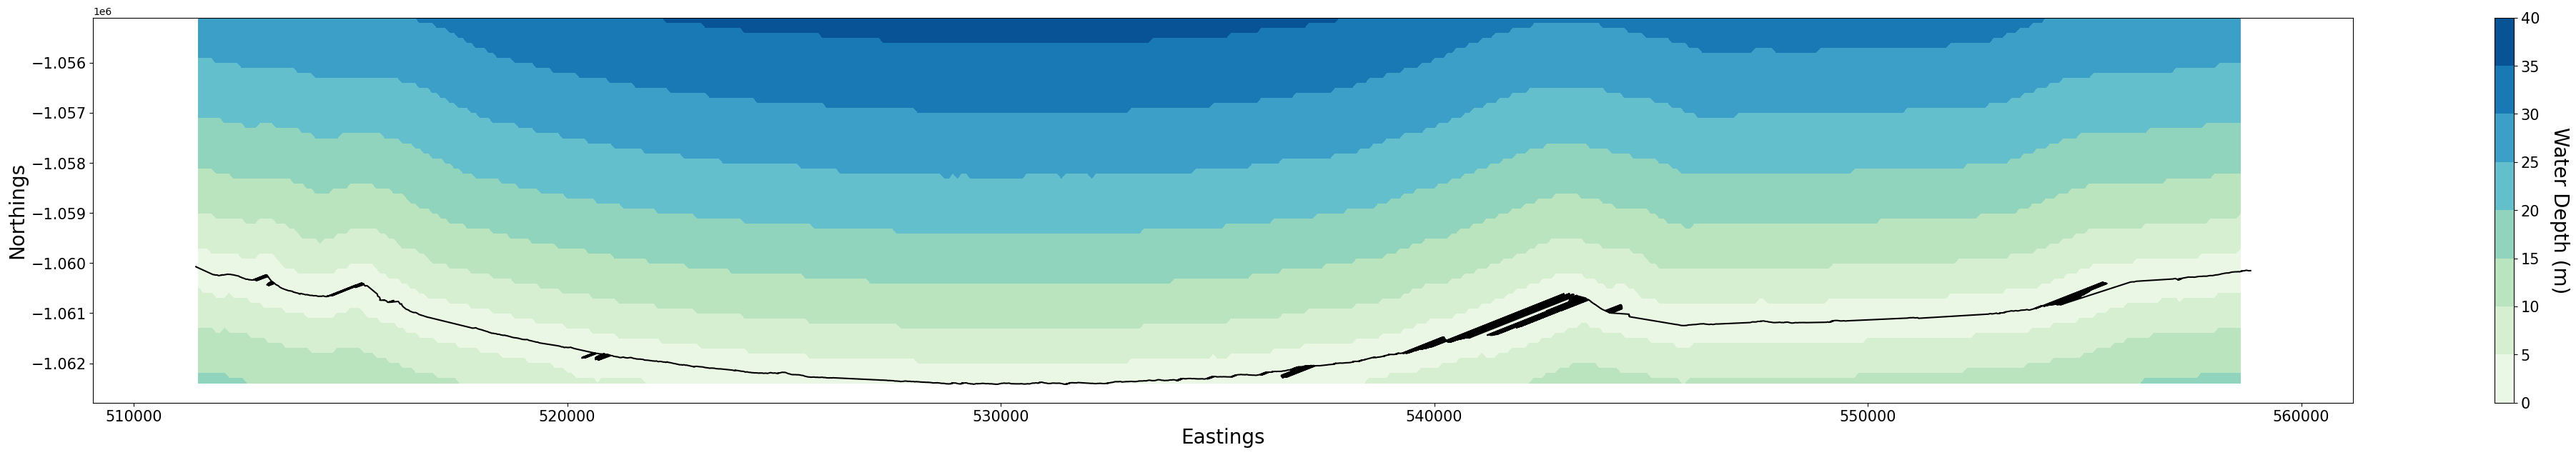

In [16]:
# If the number of x,y data points is large this may take a few minutes...
[xg,yg,elev] = shorelinetogrid(x,y,dx,dy,plotdata=True);

In [17]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_coast(domain,dx,dy):
    '''Plot the coastline.
    
    Inputs:
    ------
    domain = any 2D array (though colorbar label is specific for water depth)
    
    '''
    N,M = domain.shape
    s = M/N
    fig,ax = plt.subplots(figsize=(int(s*8),7))
    im = ax.imshow(domain, origin='lower', cmap='viridis')
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb = fig.colorbar(im,cax=cax)
    cb.ax.tick_params('both',labelsize=15)
    cb.ax.set_ylabel('Water Depth (m)',fontsize=20,rotation=-90, labelpad=30)
    y = np.linspace(0,N,4)
    x = np.linspace(0,M,4)
    Y = (y*dy/(1000)).astype('int')
    X = np.asarray(x*dx/(1000)).astype('int')
    ax.set_yticks(y)
    ax.set_xticks(x)
    ax.set_yticklabels(Y)
    ax.set_xticklabels(X)
    ax.set_xlabel('Along shore (km)',fontsize=20)
    ax.set_ylabel('Cross shore (km)',fontsize=20)
    ax.tick_params('both',labelsize=15)

In [18]:
def set_domain(pad=20):
    z_elev = elev.T.copy() # transpose of the elevations for CEM/plotting purposes
    z_elev[z_elev==-5] = -1 ## -5 is the "shoreline" flag from above.
    domain = -1*z_elev ## we want the domain to have values above sea-level to be >0 and below <0

    # neighs = np.ones([10,10])
    # total = (10**2)
    # domain = signal.convolve2d(domain,neighs/total,mode='same',boundary='symm')

    # domain[z_elev==-1] = 5 ## our shoreline got smoothed out too. This fixes that and makes sure our land is at 1m above sea level

    mat = []
    N,M = domain.shape
    for i in range(0,N):
        for j in range(0,M):
            if domain[i,j] > -1.1:
                mat.append([i,j])
    matrix = np.zeros((len(mat),2))
    for i in range(0,len(mat)):
        matrix[i,0] = mat[i][0]
        matrix[i,1] = mat[i][1]
    sortedm = matrix[matrix[:, 1].argsort()]
    Nval = sortedm[:,0]
    Mval = sortedm[:,1]
    nrow=[]
    for n in Nval:
        nrow.append(int(n))
    mcol=[]
    for m in Mval:
        mcol.append(int(m))
       
    for n in range(0,len(nrow)):
        for Nn in range(0,N):
            if Nn<nrow[n]:
                domain[Nn,mcol[n]]= 5

    N,M = domain.shape
    domnew = np.ones([N+pad,M])*5 ##here we add a "pad" to the bottom of the domain
    domnew[-N:,:] = domain # if this is undesirable, set "pad=0"
    domain = domnew


    return(domain)
   


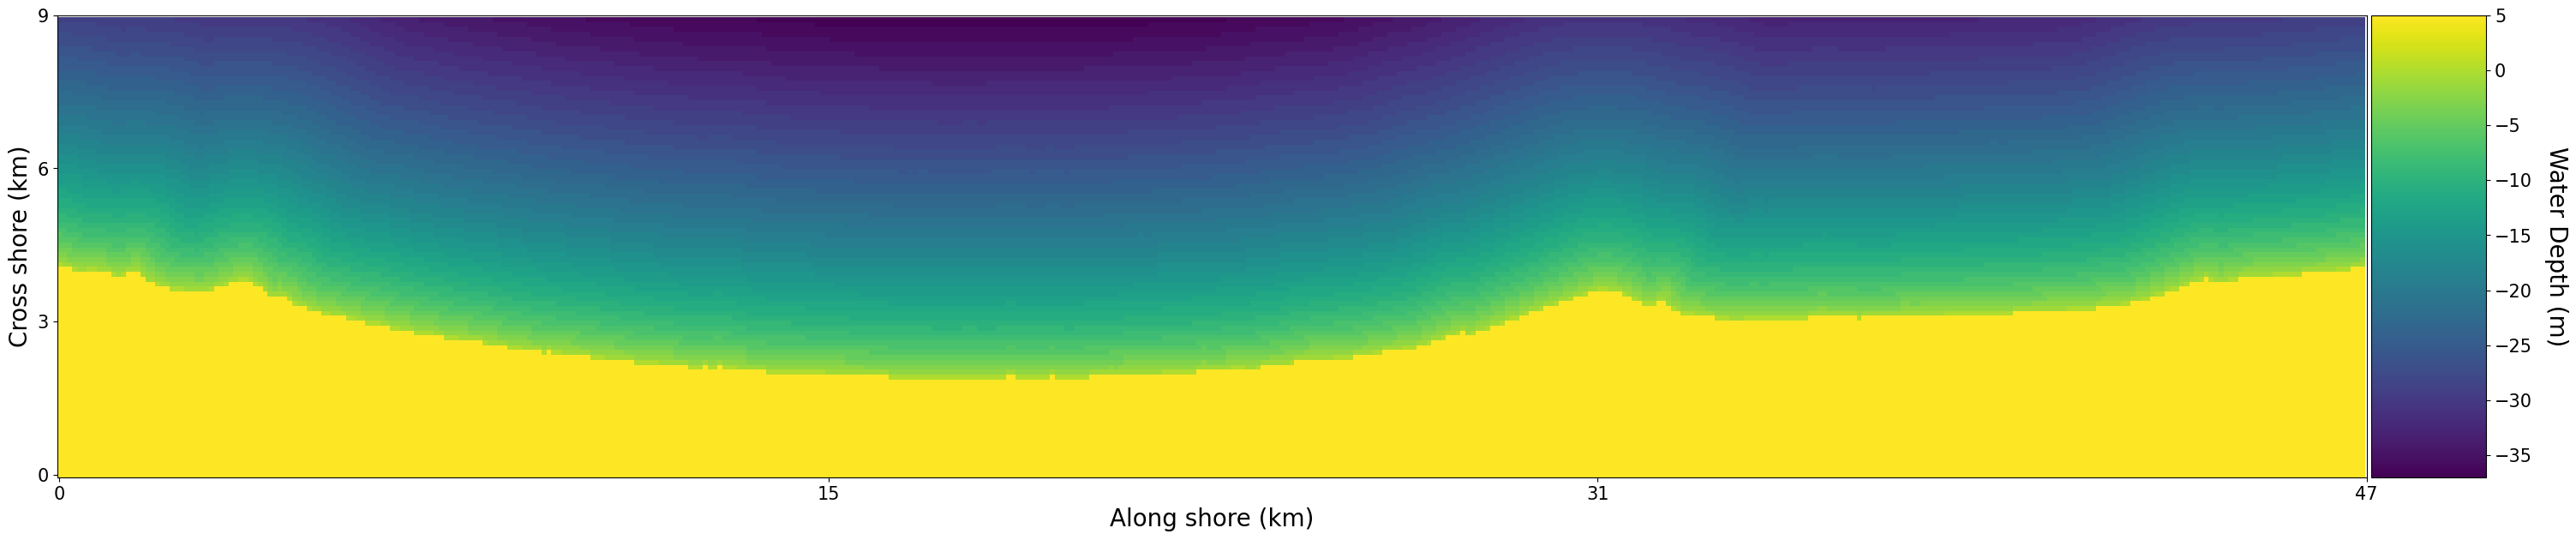

In [19]:
# we need pad to be the masked values
domain = set_domain(pad=20)
# visualize updated coastline data
plot_coast(domain,dx,dy)

In [20]:
def find_shelf_slope(pad=20): #same pad as above
    h = lambda x: 0.1*x**(2/3) ## depth equation
    profile = np.copy(domain)[:,0] ## find a nice straight column in the domain...
    ## whose depth gradient is towards the top of the domain
    x = np.arange(len(profile))*dx ## the off shore coords in [meters]
    ## find the shoreline edge and approximate the gradient using the equation from the previous notebook:
    x0 = x[pad] ## edge of beach--defined by the pad from previous step if that was used
    xf = x[-1] ## open ocean depth
    return (h(xf)-h(x0))/(xf-x0) 


shelf_slope = find_shelf_slope() ##This should be on the order of 0.001. If not you may need to find this manually
# estimation of shoreface parameters:
shoreface_slope = 4*shelf_slope ## the shoreface is steeper than the shelf
shoreface_depth = 10 # depth meters

# Model Run

In [21]:
from pymt.models import Cem, Waves

In [22]:
cem = Cem()
waves = Waves()

In [23]:
Dir

286.0

In [24]:
#convert wave direction to asymmetry term
Ap = float(abs((Dir-71)-270)/180)

In [25]:
domain.shape

(94, 472)

In [26]:
params = {
    
    ## CEM 
    'grid_spacing'    : dx,                #meters
    'shelf_slope'     : shelf_slope,
    'shoreface_depth' : shoreface_depth,   #meters
    'shoreface_slope' : shoreface_slope,
    'model__time_step': 1,               #days
    
    ##WAVES
    'wave_height' : Hs, #meters
    'wave_period' : Tp, #seconds
    'wave_angle_highness': 0.35, #important param
    'wave_angle_asymmetry': Ap
    
}

In [27]:
def initialize_models(params,domain,cem,waves,set_land=True):
    '''
    Inputs:
    ------
    
    -params = parameter dictionary
    
    -domain = initial elevation domain
        ---> domain values in (-inifinity,1] 
                -->> 1 = land, <1 = water
                
    -cem,waves = the imported models 
        --->ex: cem = pymt.Cem()
            
    '''
    p = params
    
    N,M = domain.shape

    args = cem.setup( number_of_rows = N , number_of_cols = M, 
                      grid_spacing = p['grid_spacing'] ,  shelf_slope = p['shelf_slope'] , 
                      shoreface_depth = p['shoreface_depth'] , shoreface_slope = p['shoreface_slope']
                    )
    
    
    waves.initialize(*waves.setup())
    cem.initialize(*args)

    
    waves.set_value('sea_surface_water_wave__height', p['wave_height']);
    waves.set_value('sea_surface_water_wave__period',p['wave_period']);
    waves.set_value('sea_shoreline_wave~incoming~deepwater__ashton_et_al_approach_angle_highness_parameter',
                   p['wave_angle_highness']);
    waves.set_value('sea_shoreline_wave~incoming~deepwater__ashton_et_al_approach_angle_asymmetry_parameter',
                   p['wave_angle_asymmetry']);

    if set_land==True: #if need set land elevation; 'False' used default
        cem.set_value('land_surface__elevation',domain.flatten());
    cem.set_value('model__time_step', float(p['model__time_step']));

In [28]:
initialize_models(params,domain,cem,waves)

Condition Initial 


Setting end time to 3650
CEM: trying to open file: cem.txt
CEM: line: 94, 472, 100, 1

CEM: number of rows, columns: 94, 472
*** Grid size is (0,0)
*** Requested size is (94,944)
*** New grid size is (94,944)


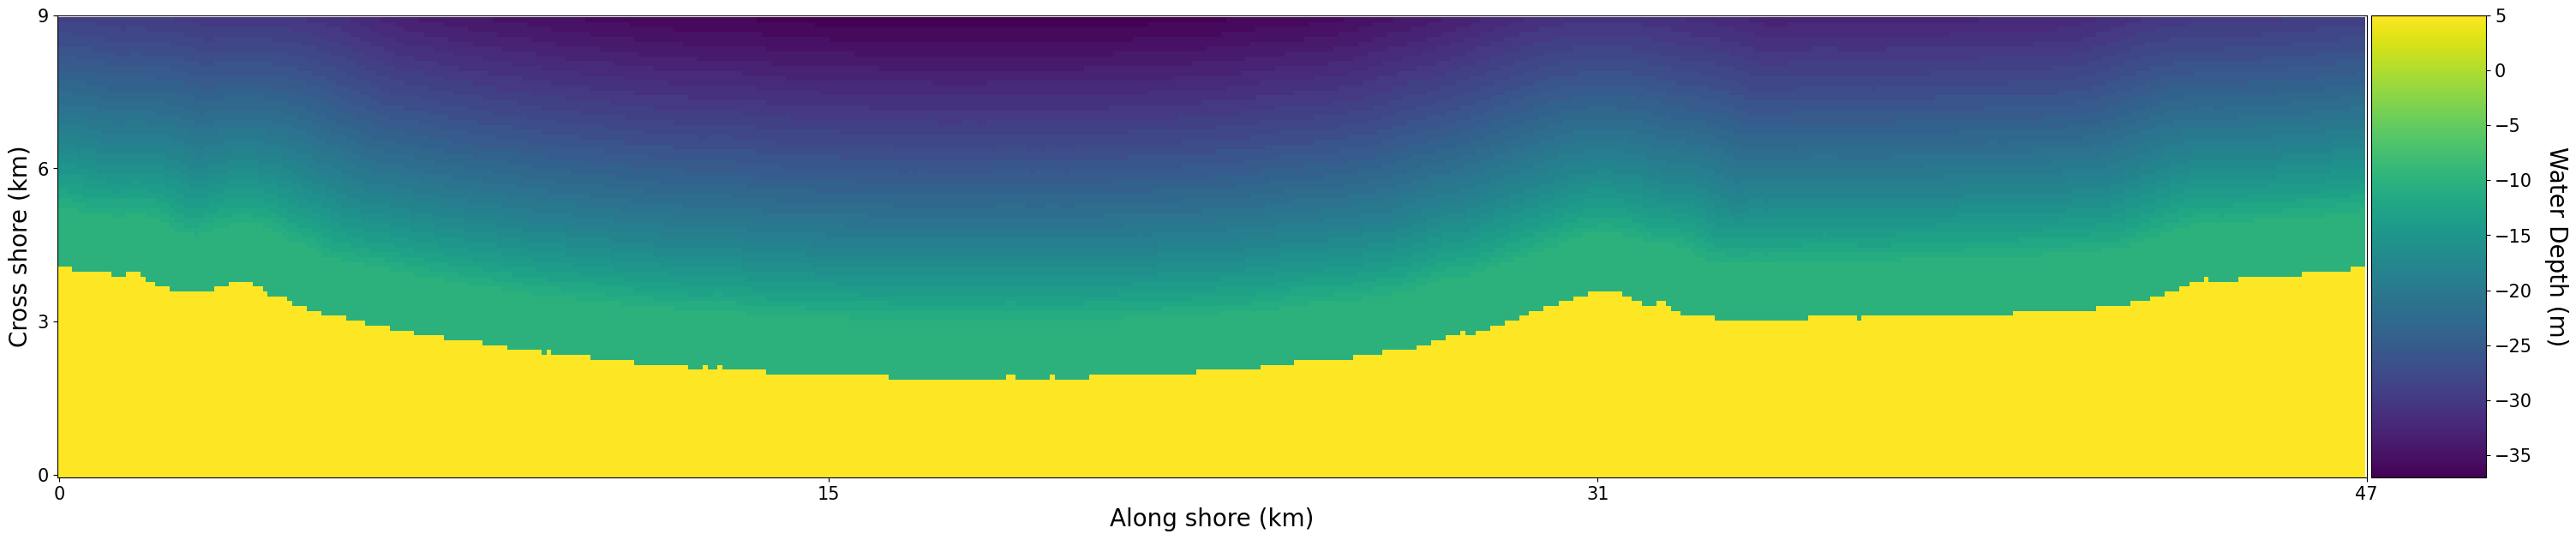

In [66]:
land = cem.get_value('land_surface__elevation')
land = land.reshape(  domain.shape  )

plot_coast(land,dx,dy)

# Add Sediment

In [67]:
land.shape

(94, 472)

In [68]:
qs = np.zeros_like(land)
qs[30, 325] = 100

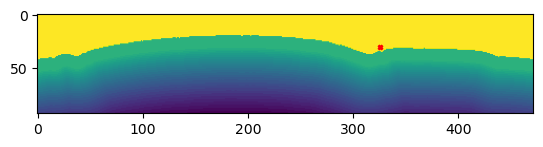

In [69]:
plt.imshow(land)
plt.scatter(325, 30, c='r', s=10, marker='X')

In [70]:
cem.get_var_units("land_surface_water_sediment~bedload__mass_flow_rate")

/var/folders/kr/t52nlmpn6n38qycgmd0q087c0000gn/T/ipykernel_49276/2188898298.py:1: DeprecationWarning: Call to deprecated method get_var_units. (use var_units)
  cem.get_var_units("land_surface_water_sediment~bedload__mass_flow_rate")


'kg / s'

In [71]:
from IPython.display import clear_output

def run_model_loop(time_years, domain ,cem ,waves, animate=True,update_ani_years=1):
    '''Loop to run the cem-waves models.
    This loop only couples the wave angles and will need to be changed to add additional coupling.
    It also assumes static variables such as sediment input and would need modification to update such variables.
    
    Inputs:
    ------
    
    -time_years = time you want to run the model in years
    
    -domain = initial elevation domain
        ---> domain values in (-inifinity,1] 
                -->> 1 = land, <1 = water
                
    -cem,waves = the imported models 
        --->ex: cem = pymt.Cem()
        
    '''
    
    alpha = 'sea_surface_water_wave__azimuth_angle_of_opposite_of_phase_velocity'
    update_ani = int(365*update_ani_years/cem.get_value('model__time_step'))
    T = int(365*time_years/cem.get_value('model__time_step'))
    dx,dy = cem.grid_spacing(cem.var_grid('sea_water__depth'))
    for time in range(T):
        waves.update()
        angle = waves.get_value(alpha)
        cem.set_value(alpha, angle)
        cem.set_value("land_surface_water_sediment~bedload__mass_flow_rate", qs)
        cem.update()
        if animate:
            if time%update_ani == 0 or time==T-1:
                clear_output(wait=True)
                plot_coast(cem.get_value('land_surface__elevation').reshape(domain.shape),dx,dy)
                plt.title('Time : '+ str(round((time*cem.get_value('model__time_step')/365)[0],1)) +' years',fontsize=20)
                plt.show()

        else:
            clear_output(wait=True)
            print('Time Step: ',time, ' days')

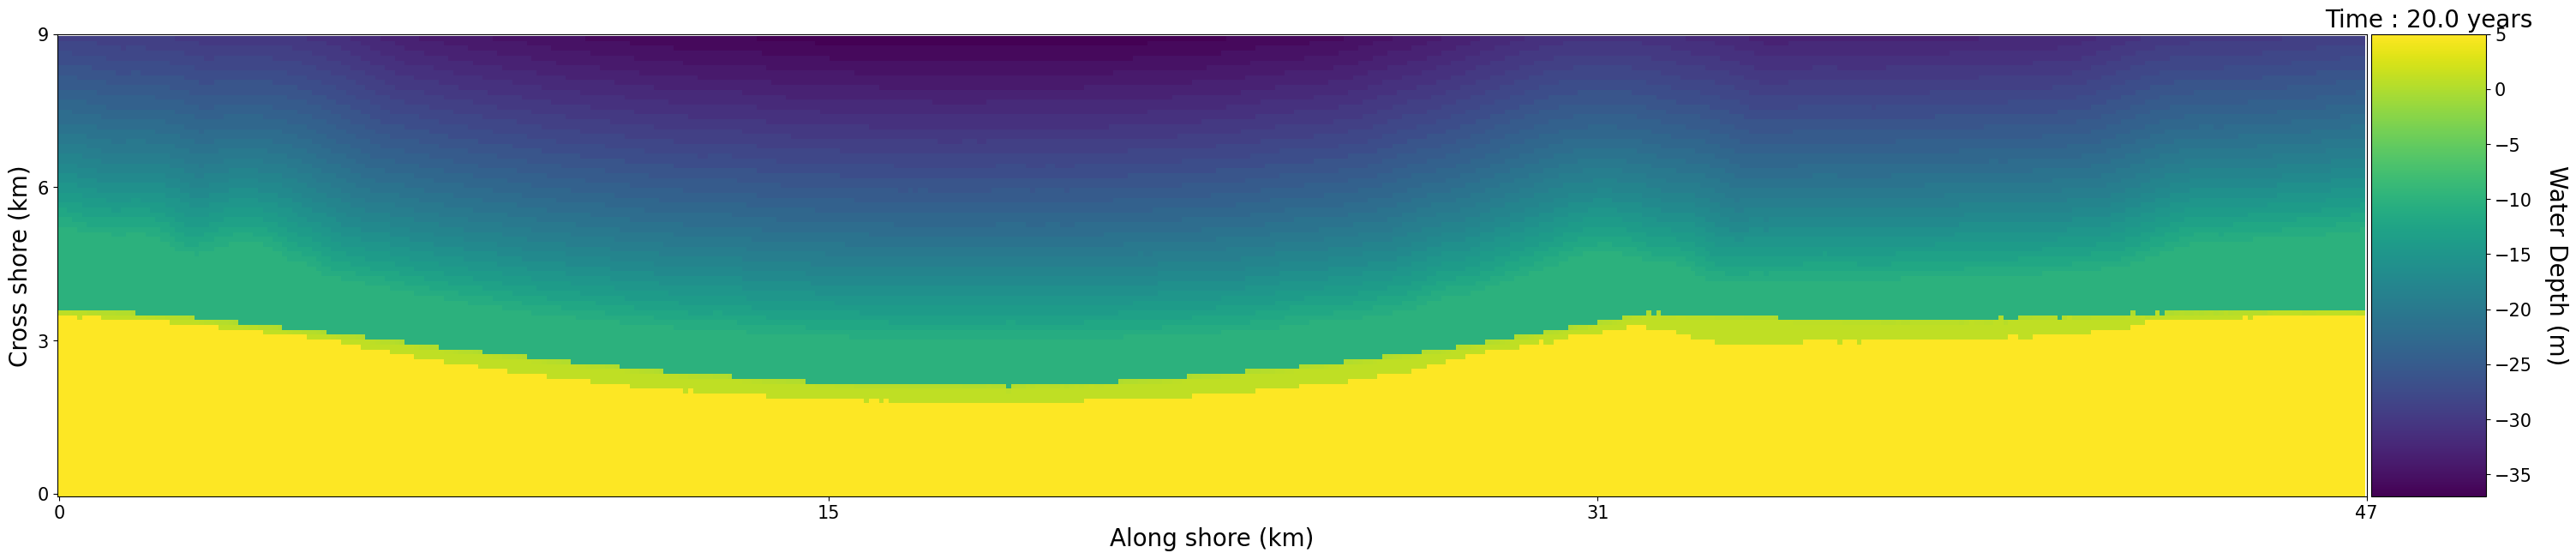

In [72]:
T = 20 #years
run_model_loop(T,domain,cem,waves,update_ani_years=1/2)